The Bitpredict project aims to predict the price of bitcoin from the data collected between 01 October 2013 to 18 May 2021 collected from [Coindesk](https://www.coindesk.com/price/bitcoin) 

##1. Importing and exploring the dataset

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-12-14 22:34:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2021-12-14 22:34:22 (5.78 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
#Importing the data
import pandas as pd

df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=['Date'], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
prices = bitcoin_prices['Price']
timesteps = bitcoin_prices.index.to_numpy()
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


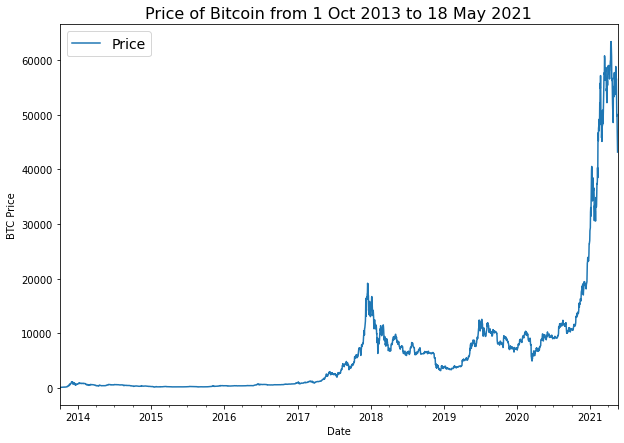

In [5]:
#plotting the timeseries
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [6]:
timesteps

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', ...,
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000'], dtype='datetime64[ns]')

##Train test split

Note that the traiditional method of splitting by selecting random points cannot be applyed here as the datapoints follow a time series pattern.

In [7]:
# Create train and test splits for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size].tolist(), prices[:split_size].tolist()

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:].tolist(), prices[split_size:].tolist()

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

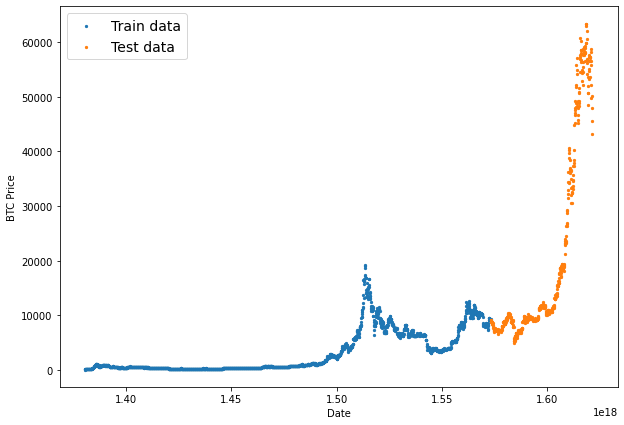

In [8]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Modelling Experiments


Two important terms, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

This project will follow the following experiment procedure:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |



Starting with a simple model first and then adding complexity as needed. 

##Model 0: Naïve forecast (baseline)

This is a very simple model and dosen't learns anything. Rather it returns the value of previous point as its forcast for next point.

In [9]:
naive_forecast = y_test[:-1]

In [10]:
#Printing the first five values of both
y_test[:5], naive_forecast[:5]

([9226.4858208826,
  8794.3586445233,
  8798.042054625601,
  9081.1868784913,
  8711.5343391679],
 [9226.4858208826,
  8794.3586445233,
  8798.042054625601,
  9081.1868784913,
  8711.5343391679])

In [11]:
#predicting last five values
y_test[-5:], naive_forecast[-5:]

([49764.1320815975,
  50032.69313676481,
  47885.6252547166,
  45604.61575361309,
  43144.471290860296],
 [52147.821186982306,
  49764.1320815975,
  50032.69313676481,
  47885.6252547166,
  45604.61575361309])

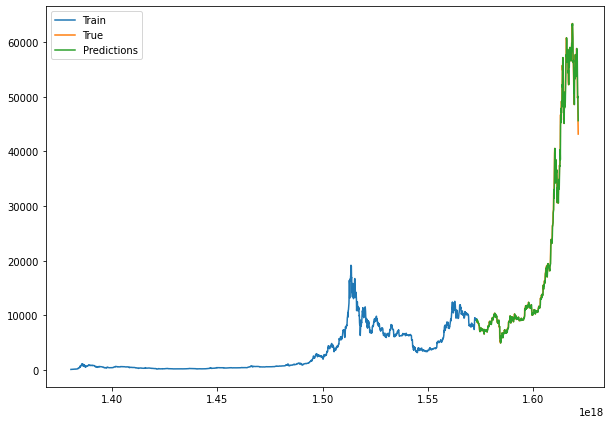

In [12]:
#plotting
plt.figure(figsize=(10,7))
plt.plot(X_train, y_train, label = 'Train')
plt.plot(X_test[1:], y_test[1:], label = 'True')
plt.plot(X_test[1:], naive_forecast, label = 'Predictions')
plt.legend()
plt.show()

In [13]:
#Writing functions for the evaluation of data
import tensorflow as tf

def mean_absolute_scaled_error(y_true, y_pred):

  """
  Implement MASE (assuming no seasonality of data).
  """

  mae =  tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive =  tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae/mae_naive

In [14]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [15]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [16]:
tf.reduce_mean(y_test).numpy()

20056.635

##Windowing dataset

In [17]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [18]:
# Test out the window labelling function

HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [19]:
import numpy as np
np.expand_dims(np.arange(7+1), axis=0) + np.expand_dims(np.arange(len(prices) - (7+1-1)), axis=0).T

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

In [20]:
import numpy as np

def make_windows(x, window_size=7, horizon=1):

  #1. Create a window of a specific size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  #2. Create a 2Darray of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  #Get the whole data
  data = np.array(x)[window_indexes]
  
  #create windows and labels
  windows, labels = data[:,:-horizon], data[:, -horizon:]

  return windows, labels

In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [22]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [23]:
# import shutil
# shutil.rmtree('All_model_checkpoints')

In [24]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [25]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

##Model 1: Dense model (window = 7, horizon = 1)

Starting by keeping it simple, model_1 will have:

 

*   A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation = 'relu', input_shape = (7,)),
                               layers.Dense(1, activation = 'linear')                        
                               ], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

model_1_history = model_1.fit(train_windows,train_labels,
                              epochs = 100,
                              batch_size = 128,
                              validation_data=(test_windows, test_labels),
                              callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_1',
                                                                             save_best_only = True))

Epoch 1/100
18/18 [==============================] - 3s 56ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6526 - val_mae: 2279.6526
Epoch 2/100
18/18 [==============================] - 1s 47ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9991 - val_mae: 1005.9991
Epoch 3/100
18/18 [==============================] - 1s 39ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2862
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 1s 39ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2238 - val_mae: 895.2238
Epoch 6/100
18/18 [==============================] - 1s 39ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1982 - val_mae: 855.1982
Epoch 7/100
18/18 [==============================] - 1s 38ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9168 - val_mae: 840.9168
Epoch 8/100
18/1

In [27]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9762 - mae: 585.9762


[585.9761962890625, 585.9761962890625]

In [28]:
#load best model and evaluate
model_1 = tf.keras.models.load_model("All_model_checkpoints/model_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9512 - mae: 568.9512


[568.951171875, 568.951171875]

In [29]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.711, 8769.886, 9015.71 , 8795.517, 8723.809, 8730.11 ,
        8691.95 , 8502.054, 8460.961, 8516.547], dtype=float32)>)

In [30]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

In [31]:
naive_results #Seems better than model_1

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

##Model 2: Dense (window = 30, horizon = 1)

In [32]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [33]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation = 'relu', input_shape = (30,)),
                               layers.Dense(1)                        
                               ], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

model_2_history = model_2.fit(train_windows,train_labels,
                              epochs = 100,
                              batch_size = 128,
                              validation_data=(test_windows, test_labels),
                              callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_2',
                                                                             save_best_only = True))

Epoch 1/100
18/18 [==============================] - 2s 48ms/step - loss: 1097.0397 - mae: 1097.0397 - val_loss: 3900.2532 - val_mae: 3900.2532
Epoch 2/100
18/18 [==============================] - 1s 40ms/step - loss: 428.0732 - mae: 428.0732 - val_loss: 1587.0747 - val_mae: 1587.0748
Epoch 3/100
18/18 [==============================] - 1s 39ms/step - loss: 279.7655 - mae: 279.7655 - val_loss: 1220.6887 - val_mae: 1220.6887
Epoch 4/100
18/18 [==============================] - 1s 39ms/step - loss: 224.3637 - mae: 224.3637 - val_loss: 1160.1571 - val_mae: 1160.1571
Epoch 5/100
18/18 [==============================] - 1s 40ms/step - loss: 187.9680 - mae: 187.9680 - val_loss: 1007.6487 - val_mae: 1007.6487
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 182.9174 - mae: 182.9174 - val_loss: 1019.5820 - val_mae: 1019.5820
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 187.7612 - mae: 187.7612 - val_loss: 1145.1761 - val_mae: 1145.1761
Epoch 

In [35]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615 - mae: 608.9615


[608.9614868164062, 608.9614868164062]

In [36]:
#load best model and evaluate
model_2 = tf.keras.models.load_model("All_model_checkpoints/model_2")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 608.9615 - mae: 608.9615


[608.9614868164062, 608.9614868164062]

In [37]:
model_2_preds = tf.squeeze(model_2.predict(test_windows))
len(model_2_preds), model_2_preds[:10]

(552, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8946.987 , 8967.846 , 8820.251 , 8615.828 , 8485.796 , 8384.62  ,
        8307.779 , 8171.7837, 8217.465 , 7839.1475], dtype=float32)>)

In [38]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.9615,
 'mape': 2.7693386,
 'mase': 1.0644706,
 'mse': 1281438.8,
 'rmse': 1132.0065}

##Model 3: Dense (window = 30, horizon = 7)

In [39]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [40]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [41]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3_history = model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_3',
                                                                save_best_only = True))

INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_3

In [42]:
# Evaluate model on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1321.5203


1321.520263671875

In [43]:
#load best model and evaluate
model_3 = tf.keras.models.load_model("All_model_checkpoints/model_3")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1237.5063


1237.50634765625

In [44]:
model_3_preds = tf.squeeze(model_3.predict(test_windows))
len(model_3_preds), model_3_preds[:10]

(551, <tf.Tensor: shape=(10, 7), dtype=float32, numpy=
 array([[9004.693 , 9048.1   , 9425.088 , 9258.258 , 9495.798 , 9558.451 ,
         9357.354 ],
        [8735.507 , 8840.304 , 9247.793 , 8885.6   , 9097.188 , 9174.328 ,
         9156.819 ],
        [8672.508 , 8782.388 , 9123.8545, 8770.37  , 9007.13  , 9003.87  ,
         9042.723 ],
        [8874.398 , 8784.737 , 9043.901 , 8943.051 , 9033.479 , 9176.488 ,
         9039.676 ],
        [8825.891 , 8777.4375, 8926.779 , 8870.178 , 9213.232 , 9268.156 ,
         8942.485 ],
        [8797.742 , 8840.091 , 9027.693 , 8974.781 , 9149.175 , 9229.459 ,
         8984.065 ],
        [8652.236 , 8803.884 , 9133.414 , 8876.115 , 8879.496 , 9111.171 ,
         8917.192 ],
        [8435.782 , 8533.1   , 8950.896 , 8667.983 , 8776.912 , 8752.908 ,
         8673.28  ],
        [8423.754 , 8317.123 , 8790.313 , 8533.363 , 8648.609 , 8623.756 ,
         8503.702 ],
        [8550.177 , 8408.629 , 8685.884 , 8591.83  , 8562.819 , 8604.392 ,
      

In [45]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.60516 ,  355.08356 ,  327.1702  ,  358.50977 ,  420.53207 ,
         537.8537  ,  545.6606  ,  485.92307 ,  584.4969  ,  687.3814  ,
         836.22675 ,  755.1571  ,  731.4959  ,  775.3398  ,  567.9547  ,
         266.80865 ,  188.80217 ,  188.1077  ,  253.09521 ,  301.4336  ,
         151.1075  ,  196.81432 ,  191.46184 ,  231.6506  ,  143.6114  ,
         122.59033 ,  132.78844 ,  190.81152 ,  179.1598  ,  228.25949 ,
         314.44028 ,  379.09283 ,  278.3254  ,  295.34604 ,  299.38525 ,
         248.64983 ,  299.75635 ,  259.6937  ,  180.30566 ,  206.72873 ,
         374.62906 ,  144.85135 ,  142.33607 ,  131.11572 ,   93.94057 ,
          54.825615,   73.7943  ,  103.59996 ,  121.33378 ,  168.67215 ,
         183.90945 ,  152.25307 ,  186.57129 ,  146.91309 ,  240.42955 ,
         351.00668 ,  540.9516  ,  549.15674 ,  521.2422  ,  526.8553  ,
         453.36307 ,  257.98166 ,  277.29492 ,  301.82465 ,  455.71756 ,
         458.96002 ,  503.44427 ,  522.3119 

Since the horizon has the value of 7 we are getting evaluation in terms of metrics.

In this case it is better to rewrite the evaluate function.

In [46]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [47]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7479}

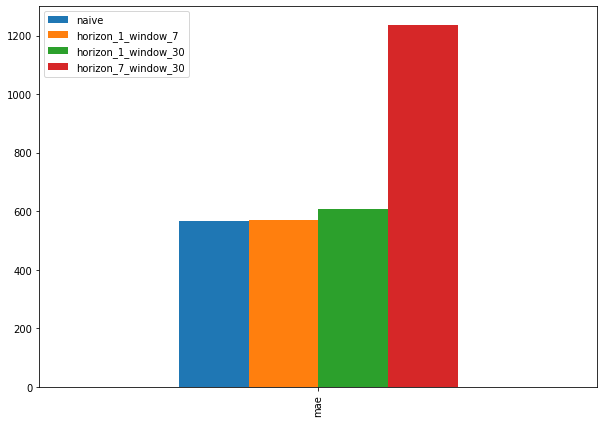

In [48]:
#Plotting results so far

pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

##Model 4: CNN

In [49]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [50]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

The CNN model takes inputs in dimension different that the one we have produced above. It is better to create a expand dim lambda layer so that the window elements can be reshaped.

In [51]:
model_4 = tf.keras.Sequential([
                      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                      tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                      tf.keras.layers.Dense(HORIZON)
])

model_4.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam())

model_4_history = model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_4',
                                                                save_best_only = True))

INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4/assets
INFO:tensorflow:Assets written to: All_model_checkpoints/model_4

In [52]:
# Evaluate model on test data
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 630.4081


630.4081420898438

In [53]:

#load best model and evaluate
model_4 = tf.keras.models.load_model("All_model_checkpoints/model_4")
model_4.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 3ms/step - loss: 569.6168


569.6167602539062

In [54]:
model_4_preds = tf.squeeze(model_4.predict(test_windows))
len(model_4_preds), model_4_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8910.765, 8808.881, 9009.132, 8804.391, 8759.231, 8738.199,
        8705.466, 8556.177, 8469.612, 8534.405], dtype=float32)>)

In [55]:
# Get model_3 results aggregated to single values
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.6167,
 'mape': 2.5637598,
 'mase': 1.0006588,
 'mse': 1185832.6,
 'rmse': 1088.9595}

##Model 5: RNN - LSTM Layer

In [56]:
model_5 = tf.keras.Sequential([
                      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                      tf.keras.layers.LSTM(128, activation='relu'),
                      tf.keras.layers.Dense(HORIZON)
])

model_5.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam())

model_5_history = model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_5',
                                                                save_best_only = True))

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2804.5286INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 5s 179ms/step - loss: 2804.5286 - val_loss: 14407.9424
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 1765.1569INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 142ms/step - loss: 1678.9122 - val_loss: 6816.4858
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 531.5542INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 524.2725 - val_loss: 1417.5562
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 234.5937INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 231.5581 - val_loss: 1229.8317
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 190.7559INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 166ms/step - loss: 188.7931 - val_loss: 1032.7042
Epoch 6/100
15/18 [========================>.....] - ETA: 0s - loss: 183.8386INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 147ms/step - loss: 183.4289 - val_loss: 1024.7174
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 184.0138 - val_loss: 1045.4136
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 181.5940 - val_loss: 1052.2739
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 179.9724 - val_loss: 1038.6570
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 177.6686INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 147ms/step - loss: 179.0035 - val_loss: 1017.4258
Epoch 11/100
18/18 [==============================] - 0s 10ms/step - loss: 178.9746 - val_loss: 1018.9355
Epoch 12/100
14/18 [======================>.......] - ETA: 0s - loss: 178.2365INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 168ms/step - loss: 177.1979 - val_loss: 1013.7540
Epoch 13/100
15/18 [========================>.....] - ETA: 0s - loss: 174.8192INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 142ms/step - loss: 175.6613 - val_loss: 990.5361
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 174.3959 - val_loss: 1018.7653
Epoch 15/100
18/18 [==============================] - 0s 10ms/step - loss: 173.8794 - val_loss: 1004.4620
Epoch 16/100
15/18 [========================>.....] - ETA: 0s - loss: 170.4693INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 171.9816 - val_loss: 962.4548
Epoch 17/100
18/18 [==============================] - 0s 11ms/step - loss: 170.6799 - val_loss: 1019.6190
Epoch 18/100
18/18 [==============================] - 0s 10ms/step - loss: 170.2047 - val_loss: 1000.7981
Epoch 19/100
18/18 [==============================] - 0s 10ms/step - loss: 168.6344 - val_loss: 992.4367
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 169.2807INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 167.9839 - val_loss: 938.8922
Epoch 21/100
18/18 [==============================] - 0s 10ms/step - loss: 165.4699 - val_loss: 946.0856
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 165.0076INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 166ms/step - loss: 164.1094 - val_loss: 935.7051
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 161.9545INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 164.1087 - val_loss: 924.3380
Epoch 24/100
18/18 [==============================] - 0s 10ms/step - loss: 161.9579 - val_loss: 939.8121
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 160.6119INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 159.8659 - val_loss: 916.8152
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 158.2294INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 170ms/step - loss: 158.6101 - val_loss: 895.0463
Epoch 27/100
18/18 [==============================] - 0s 9ms/step - loss: 158.1184 - val_loss: 907.8393
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 156.7880INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 146ms/step - loss: 156.9878 - val_loss: 886.9715
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 155.0709INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 154.1601 - val_loss: 876.3431
Epoch 30/100
17/18 [===========================>..] - ETA: 0s - loss: 153.5600INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 167ms/step - loss: 153.6441 - val_loss: 860.1538
Epoch 31/100
15/18 [========================>.....] - ETA: 0s - loss: 149.0244INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 150ms/step - loss: 151.5153 - val_loss: 841.0349
Epoch 32/100
18/18 [==============================] - 0s 11ms/step - loss: 150.4960 - val_loss: 842.1405
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 149.9265 - val_loss: 939.7573
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 149.0098INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 146ms/step - loss: 150.0827 - val_loss: 822.2396
Epoch 35/100
18/18 [==============================] - 0s 13ms/step - loss: 145.3268 - val_loss: 823.0300
Epoch 36/100
16/18 [=========================>....] - ETA: 0s - loss: 144.4810INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 145.4728 - val_loss: 799.2786
Epoch 37/100
18/18 [==============================] - 0s 9ms/step - loss: 143.8494 - val_loss: 800.8018
Epoch 38/100
18/18 [==============================] - 0s 11ms/step - loss: 141.7234 - val_loss: 800.9574
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 143.8358INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 167ms/step - loss: 141.3175 - val_loss: 775.6818
Epoch 40/100
16/18 [=========================>....] - ETA: 0s - loss: 142.3323INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 146ms/step - loss: 141.2191 - val_loss: 769.5858
Epoch 41/100
14/18 [======================>.......] - ETA: 0s - loss: 141.4555INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 148ms/step - loss: 137.3629 - val_loss: 765.7424
Epoch 42/100
15/18 [========================>.....] - ETA: 0s - loss: 134.5447INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 163ms/step - loss: 136.8411 - val_loss: 761.1289
Epoch 43/100
18/18 [==============================] - 0s 9ms/step - loss: 135.4540 - val_loss: 774.6844
Epoch 44/100
16/18 [=========================>....] - ETA: 0s - loss: 134.5014INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 149ms/step - loss: 133.3869 - val_loss: 743.4340
Epoch 45/100
18/18 [==============================] - 0s 10ms/step - loss: 132.5587 - val_loss: 760.9282
Epoch 46/100
16/18 [=========================>....] - ETA: 0s - loss: 132.5476INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 131.6159 - val_loss: 732.9542
Epoch 47/100
15/18 [========================>.....] - ETA: 0s - loss: 126.0097INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 151ms/step - loss: 130.4518 - val_loss: 728.5362
Epoch 48/100
18/18 [==============================] - 0s 11ms/step - loss: 129.3006 - val_loss: 730.7258
Epoch 49/100
13/18 [====================>.........] - ETA: 0s - loss: 130.4343INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 172ms/step - loss: 128.2550 - val_loss: 713.6846
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 130.9321 - val_loss: 726.2835
Epoch 51/100
18/18 [==============================] - 0s 12ms/step - loss: 131.9076 - val_loss: 740.8910
Epoch 52/100
15/18 [========================>.....] - ETA: 0s - loss: 136.9305INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 132.9753 - val_loss: 695.1912
Epoch 53/100
18/18 [==============================] - 0s 10ms/step - loss: 127.3892 - val_loss: 704.2792
Epoch 54/100
18/18 [==============================] - 0s 11ms/step - loss: 125.2439 - val_loss: 709.9711
Epoch 55/100
17/18 [===========================>..] - ETA: 0s - loss: 124.8611INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 143ms/step - loss: 123.6096 - val_loss: 684.1490
Epoch 56/100
18/18 [==============================] - 0s 12ms/step - loss: 123.9667 - val_loss: 686.6760
Epoch 57/100
17/18 [===========================>..] - ETA: 0s - loss: 124.2706INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 171ms/step - loss: 123.6994 - val_loss: 672.1978
Epoch 58/100
13/18 [====================>.........] - ETA: 0s - loss: 121.5752INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 147ms/step - loss: 120.3909 - val_loss: 662.6537
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 120.8324INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 119.6290 - val_loss: 659.8716
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 119.4309 - val_loss: 664.5811
Epoch 61/100
18/18 [==============================] - 0s 10ms/step - loss: 119.8358 - val_loss: 699.0834
Epoch 62/100
18/18 [==============================] - 0s 11ms/step - loss: 122.4444 - val_loss: 721.3209
Epoch 63/100
13/18 [====================>.........] - ETA: 0s - loss: 126.0722INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 146ms/step - loss: 122.2151 - val_loss: 652.8698
Epoch 64/100
13/18 [====================>.........] - ETA: 0s - loss: 120.2901INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 169ms/step - loss: 117.1771 - val_loss: 646.3103
Epoch 65/100
16/18 [=========================>....] - ETA: 0s - loss: 116.9691INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 116.9157 - val_loss: 637.1575
Epoch 66/100
18/18 [==============================] - 0s 10ms/step - loss: 116.5772 - val_loss: 659.5068
Epoch 67/100
16/18 [=========================>....] - ETA: 0s - loss: 113.2205INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 116.1259 - val_loss: 631.0637
Epoch 68/100
15/18 [========================>.....] - ETA: 0s - loss: 118.0171INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 143ms/step - loss: 116.4260 - val_loss: 628.3860
Epoch 69/100
18/18 [==============================] - 0s 10ms/step - loss: 118.3536 - val_loss: 633.6782
Epoch 70/100
16/18 [=========================>....] - ETA: 0s - loss: 115.7094INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 166ms/step - loss: 115.4718 - val_loss: 623.8244
Epoch 71/100
18/18 [==============================] - 0s 10ms/step - loss: 115.2069 - val_loss: 664.7181
Epoch 72/100
18/18 [==============================] - 0s 9ms/step - loss: 119.2440 - val_loss: 643.7936
Epoch 73/100
15/18 [========================>.....] - ETA: 0s - loss: 117.2540INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 144ms/step - loss: 116.7145 - val_loss: 619.4916
Epoch 74/100
18/18 [==============================] - 0s 10ms/step - loss: 115.5550 - val_loss: 638.7492
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 114.7679 - val_loss: 634.7174
Epoch 76/100
16/18 [=========================>....] - ETA: 0s - loss: 115.2117INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 148ms/step - loss: 114.0962 - val_loss: 611.9473
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 114.7743 - val_loss: 661.0469
Epoch 78/100
18/18 [==============================] - 0s 9ms/step - loss: 116.2745 - val_loss: 620.1562
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 113.7442INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 162ms/step - loss: 113.2632 - val_loss: 607.7816
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 112.4564 - val_loss: 636.8754
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 112.5762 - val_loss: 641.9697
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 116.1159 - val_loss: 622.5283
Epoch 83/100
18/18 [==============================] - 0s 11ms/step - loss: 113.2163 - val_loss: 677.9759
Epoch 84/100
18/18 [==============================] - 0s 11ms/step - loss: 115.7278 - val_loss: 624.4727
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5612 - val_loss: 616.4445
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 113.8628 - val_loss: 614.4949
Epoch 87/100
15/18 [========================>.....] - ETA: 0s - loss: 112.7815INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 143ms/step - loss: 112.6459 - val_loss: 599.8044
Epoch 88/100
18/18 [==============================] - 0s 10ms/step - loss: 111.2772 - val_loss: 600.4467
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 111.0189 - val_loss: 618.0690
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 115.3486 - val_loss: 628.9528
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 114.2048 - val_loss: 650.6410
Epoch 92/100
16/18 [=========================>....] - ETA: 0s - loss: 111.7632INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 112.2565 - val_loss: 597.7681
Epoch 93/100
18/18 [==============================] - ETA: 0s - loss: 111.9666INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 175ms/step - loss: 111.9666 - val_loss: 595.6187
Epoch 94/100
18/18 [==============================] - 0s 10ms/step - loss: 110.5860 - val_loss: 595.9861
Epoch 95/100
14/18 [======================>.......] - ETA: 0s - loss: 111.7321INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 110.5470 - val_loss: 593.5345
Epoch 96/100
18/18 [==============================] - 0s 11ms/step - loss: 112.4156 - val_loss: 606.3714
Epoch 97/100
18/18 [==============================] - 0s 10ms/step - loss: 114.6077 - val_loss: 656.9077
Epoch 98/100
15/18 [========================>.....] - ETA: 0s - loss: 115.7988INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 2s 145ms/step - loss: 113.8207 - val_loss: 591.5417
Epoch 99/100
15/18 [========================>.....] - ETA: 0s - loss: 109.9823INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_5/assets


18/18 [==============================] - 3s 147ms/step - loss: 111.0679 - val_loss: 590.4626
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 115.8838 - val_loss: 611.4272


In [57]:
# Evaluate model on test data
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 611.4272


611.4271850585938

In [58]:

#load best model and evaluate
model_5 = tf.keras.models.load_model("All_model_checkpoints/model_5")
model_5.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 3ms/step - loss: 590.4626


590.4625854492188

In [59]:

model_5_preds = tf.squeeze(model_5.predict(test_windows))
len(model_5_preds), model_5_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8959.087 , 8822.446 , 8984.339 , 8800.15  , 8746.758 , 8760.836 ,
        8705.3545, 8550.677 , 8488.498 , 8522.442 ], dtype=float32)>)

In [60]:
# Get model_3 results aggregated to single values
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 590.4626,
 'mape': 2.6537366,
 'mase': 1.0372792,
 'mse': 1249924.9,
 'rmse': 1118.0004}

##Adding block rewards as a parameter

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

In [61]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25


block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64("2020-05-11")

In [62]:
block_reward_2_days =  (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days =  (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [63]:
bitcoin_prices.index[0], bitcoin_prices.index[-1]

(Timestamp('2013-10-01 00:00:00'), Timestamp('2021-05-18 00:00:00'))

In [64]:
bitcoin_block_reward = bitcoin_prices.copy()

bitcoin_block_reward['block reward'] = None

bitcoin_block_reward.loc[:'2016-07-09', 'block reward'] = 25
bitcoin_block_reward.loc['2016-07-09':'2020-05-11', 'block reward'] = 12.5
bitcoin_block_reward.loc['2020-05-11':, 'block reward'] = 6.25

bitcoin_block_reward.head()

,Price,block reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [65]:
bitcoin_block_reward['block reward'].unique()

array([25, 12.5, 6.25], dtype=object)

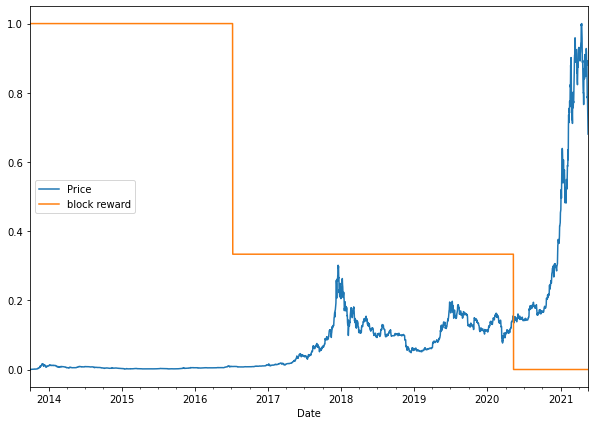

In [66]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_block_reward[["Price", "block reward"]]), # we need to scale the data first
                                     columns=bitcoin_block_reward.columns,
                                     index=bitcoin_block_reward.index)
scaled_price_block_df.plot(figsize=(10, 7));

##Making a windowed dataframe

In [67]:
bitcoin_prices_windowed = bitcoin_block_reward.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods = i+1)

bitcoin_prices_windowed.head(10)

,Price,block reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [68]:
#Creatinf features and labels
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [69]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [70]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([],name = 'model_6_dense_multivariate')

model_6.add(tf.keras.layers.Dense(128, activation='relu'))
model_6.add(tf.keras.layers.Dense(HORIZON))

model_6.compile(loss='mae', optimizer = tf.keras.optimizers.Adam())

model_6_history = model_6.fit(X_train,
            y_train,
            epochs = 100,
            batch_size = 128,
            validation_data = (X_test, y_test),
            callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='All_model_checkpoints/model_6'))


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1234.6805INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 48ms/step - loss: 1234.6805 - val_loss: 2061.8848
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 366.3868INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 351.5053 - val_loss: 1908.6812
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 240.1740INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 235.4153 - val_loss: 1329.0609
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 208.6112INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 208.6112 - val_loss: 1102.1311
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 198.7767INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 196.5770 - val_loss: 1107.8497
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 187.2244INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 187.2244 - val_loss: 1036.1698
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 187.4053INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 182.0245 - val_loss: 1019.2944
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 175.4780INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 36ms/step - loss: 175.7059 - val_loss: 977.8504
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 170.3185INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 170.1784 - val_loss: 954.4049
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 164.4430INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 164.4430 - val_loss: 913.5159
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 161.4382INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 158.6892 - val_loss: 874.2512
Epoch 12/100
15/18 [========================>.....] - ETA: 0s - loss: 153.0774INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 152.0732 - val_loss: 861.0421
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 151.1057INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 151.1057 - val_loss: 886.1205
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 144.7363INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 54ms/step - loss: 147.5482 - val_loss: 837.8616
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 142.5062INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 142.3497 - val_loss: 794.4787
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 140.2361INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 137.5206 - val_loss: 778.4051
Epoch 17/100
17/18 [===========================>..] - ETA: 0s - loss: 135.2092INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 135.8191 - val_loss: 772.4531
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 138.6812INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 134.8562 - val_loss: 747.4803
Epoch 19/100
17/18 [===========================>..] - ETA: 0s - loss: 131.1884INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 130.3347 - val_loss: 761.0551
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 128.4480INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 128.6775 - val_loss: 701.8981
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 128.7350INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 129.5576 - val_loss: 691.0132
Epoch 22/100
14/18 [======================>.......] - ETA: 0s - loss: 131.2601INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 125.8060 - val_loss: 684.4122
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 124.5540INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 125.5263 - val_loss: 692.1297
Epoch 24/100
17/18 [===========================>..] - ETA: 0s - loss: 123.8994INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 122.4765 - val_loss: 674.2216
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 124.1111INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 121.1171 - val_loss: 669.6432
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 131.5955INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 127.2623 - val_loss: 690.0403
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 125.5024INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 124.6204 - val_loss: 643.9723
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 118.2544INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 118.2544 - val_loss: 656.2765
Epoch 29/100
17/18 [===========================>..] - ETA: 0s - loss: 117.4213INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 119.6374 - val_loss: 633.4545
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 119.5001INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 119.5001 - val_loss: 625.3950
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 114.5633INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 114.5633 - val_loss: 668.5065
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 116.9750INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 116.9750 - val_loss: 617.1058
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 116.2992INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 115.2438 - val_loss: 649.0998
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 114.5187INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 114.5187 - val_loss: 632.1383
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 113.6357INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 113.6357 - val_loss: 607.4178
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 115.0067INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 58ms/step - loss: 115.2605 - val_loss: 626.4328
Epoch 37/100
15/18 [========================>.....] - ETA: 0s - loss: 116.2274INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 113.7021 - val_loss: 606.2327
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 111.4061INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 111.4061 - val_loss: 603.2928
Epoch 39/100
18/18 [==============================] - ETA: 0s - loss: 112.7722INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 112.7722 - val_loss: 596.0070
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 110.8327INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 110.5418 - val_loss: 593.2180
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 114.4296INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 110.8671 - val_loss: 609.1075
Epoch 42/100
15/18 [========================>.....] - ETA: 0s - loss: 111.0049INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 115.7249 - val_loss: 607.4883
Epoch 43/100
17/18 [===========================>..] - ETA: 0s - loss: 110.7993INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 36ms/step - loss: 111.3313 - val_loss: 606.2040
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 65.3244INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 109.7027 - val_loss: 586.1223
Epoch 45/100
17/18 [===========================>..] - ETA: 0s - loss: 108.2186INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 107.8748 - val_loss: 593.8456
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 109.8641INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 109.8641 - val_loss: 586.4590
Epoch 47/100
18/18 [==============================] - ETA: 0s - loss: 112.3587INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 112.3587 - val_loss: 655.4493
Epoch 48/100
17/18 [===========================>..] - ETA: 0s - loss: 109.1544INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 36ms/step - loss: 109.1614 - val_loss: 598.7241
Epoch 49/100
17/18 [===========================>..] - ETA: 0s - loss: 109.5578INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 109.3029 - val_loss: 589.2495
Epoch 50/100
17/18 [===========================>..] - ETA: 0s - loss: 111.3764INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 111.1971 - val_loss: 649.3796
Epoch 51/100
16/18 [=========================>....] - ETA: 0s - loss: 110.6475INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 110.8514 - val_loss: 602.7673
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 112.2596INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 111.8331 - val_loss: 599.2969
Epoch 53/100
17/18 [===========================>..] - ETA: 0s - loss: 111.3372INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 110.8895 - val_loss: 652.1648
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 108.5393INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 35ms/step - loss: 113.8169 - val_loss: 600.8464
Epoch 55/100
15/18 [========================>.....] - ETA: 0s - loss: 114.1359INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 110.4069 - val_loss: 575.7761
Epoch 56/100
18/18 [==============================] - ETA: 0s - loss: 108.6609INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 108.6609 - val_loss: 785.9771
Epoch 57/100
15/18 [========================>.....] - ETA: 0s - loss: 128.2607INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 124.9824 - val_loss: 670.3802
Epoch 58/100
15/18 [========================>.....] - ETA: 0s - loss: 113.3893INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 112.8591 - val_loss: 580.2890
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 108.5197INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 58ms/step - loss: 107.2513 - val_loss: 597.5096
Epoch 60/100
15/18 [========================>.....] - ETA: 0s - loss: 110.2417INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 109.2322 - val_loss: 632.2961
Epoch 61/100
17/18 [===========================>..] - ETA: 0s - loss: 110.4241INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 109.3519 - val_loss: 591.5418
Epoch 62/100
15/18 [========================>.....] - ETA: 0s - loss: 110.7293INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 108.4084 - val_loss: 617.5816
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 113.8892INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 113.5326 - val_loss: 613.1481
Epoch 64/100
17/18 [===========================>..] - ETA: 0s - loss: 110.4711INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 110.6625 - val_loss: 689.1802
Epoch 65/100
16/18 [=========================>....] - ETA: 0s - loss: 111.6607INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 112.0475 - val_loss: 575.5552
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 111.4886INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 111.2830 - val_loss: 590.7814
Epoch 67/100
17/18 [===========================>..] - ETA: 0s - loss: 105.1474INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 106.7917 - val_loss: 586.8853
Epoch 68/100
17/18 [===========================>..] - ETA: 0s - loss: 112.9461INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 112.2987 - val_loss: 696.5306
Epoch 69/100
17/18 [===========================>..] - ETA: 0s - loss: 122.3725INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 124.7808 - val_loss: 698.5281
Epoch 70/100
16/18 [=========================>....] - ETA: 0s - loss: 118.8946INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 119.3443 - val_loss: 581.2116
Epoch 71/100
15/18 [========================>.....] - ETA: 0s - loss: 109.4995INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 109.9960 - val_loss: 607.6747
Epoch 72/100
16/18 [=========================>....] - ETA: 0s - loss: 104.9060INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 106.7710 - val_loss: 573.6154
Epoch 73/100
14/18 [======================>.......] - ETA: 0s - loss: 111.1580INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 110.2485 - val_loss: 618.8967
Epoch 74/100
16/18 [=========================>....] - ETA: 0s - loss: 105.1290INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 105.5330 - val_loss: 574.9466
Epoch 75/100
18/18 [==============================] - ETA: 0s - loss: 107.3177INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 107.3177 - val_loss: 606.1979
Epoch 76/100
13/18 [====================>.........] - ETA: 0s - loss: 109.1772INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 107.8084 - val_loss: 582.2418
Epoch 77/100
18/18 [==============================] - ETA: 0s - loss: 107.2528INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 107.2528 - val_loss: 571.8574
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 107.1715INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 106.2309 - val_loss: 572.2839
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 106.1541INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 105.8568 - val_loss: 596.5475
Epoch 80/100
16/18 [=========================>....] - ETA: 0s - loss: 108.5481INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 107.8419 - val_loss: 577.2410
Epoch 81/100
18/18 [==============================] - ETA: 0s - loss: 105.1101INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 105.1101 - val_loss: 568.4908
Epoch 82/100
16/18 [=========================>....] - ETA: 0s - loss: 113.3160INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 61ms/step - loss: 114.1867 - val_loss: 592.5623
Epoch 83/100
14/18 [======================>.......] - ETA: 0s - loss: 106.5246INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 41ms/step - loss: 107.9631 - val_loss: 651.6234
Epoch 84/100
17/18 [===========================>..] - ETA: 0s - loss: 110.1413INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 109.6690 - val_loss: 568.9351
Epoch 85/100
17/18 [===========================>..] - ETA: 0s - loss: 104.4011INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 105.8219 - val_loss: 571.5342
Epoch 86/100
17/18 [===========================>..] - ETA: 0s - loss: 103.0562INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 104.8628 - val_loss: 579.3867
Epoch 87/100
17/18 [===========================>..] - ETA: 0s - loss: 105.0777INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 104.7148 - val_loss: 582.9193
Epoch 88/100
18/18 [==============================] - ETA: 0s - loss: 106.8899INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 106.8899 - val_loss: 569.0833
Epoch 89/100
18/18 [==============================] - ETA: 0s - loss: 105.4376INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 105.4376 - val_loss: 569.3450
Epoch 90/100
18/18 [==============================] - ETA: 0s - loss: 105.1590INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 37ms/step - loss: 105.1590 - val_loss: 599.0229
Epoch 91/100
17/18 [===========================>..] - ETA: 0s - loss: 111.8075INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 112.2914 - val_loss: 618.5336
Epoch 92/100
17/18 [===========================>..] - ETA: 0s - loss: 107.2812INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 107.1306 - val_loss: 591.9597
Epoch 93/100
16/18 [=========================>....] - ETA: 0s - loss: 117.8337INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 115.7380 - val_loss: 639.2241
Epoch 94/100
18/18 [==============================] - ETA: 0s - loss: 108.3453INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 40ms/step - loss: 108.3453 - val_loss: 578.5894
Epoch 95/100
15/18 [========================>.....] - ETA: 0s - loss: 103.4830INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 39ms/step - loss: 104.2910 - val_loss: 568.2698
Epoch 96/100
17/18 [===========================>..] - ETA: 0s - loss: 105.4387INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 106.5346 - val_loss: 606.5500
Epoch 97/100
16/18 [=========================>....] - ETA: 0s - loss: 106.1592INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 107.1290 - val_loss: 585.3795
Epoch 98/100
15/18 [========================>.....] - ETA: 0s - loss: 107.3591INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 105.8151 - val_loss: 574.4843
Epoch 99/100
16/18 [=========================>....] - ETA: 0s - loss: 104.3112INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 105.8276 - val_loss: 567.5873
Epoch 100/100
17/18 [===========================>..] - ETA: 0s - loss: 115.4883INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


INFO:tensorflow:Assets written to: All_model_checkpoints/model_6/assets


18/18 [==============================] - 1s 38ms/step - loss: 114.9743 - val_loss: 654.9899


In [71]:
# Evaluate model on test data
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 654.9899


654.9898681640625

In [72]:
#load best model and evaluate
model_6 = tf.keras.models.load_model("All_model_checkpoints/model_6")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 654.9899


654.9898681640625

In [73]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
len(model_6_preds), model_6_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8685.809, 8613.057, 8890.607, 8608.052, 8573.844, 8619.947,
        8517.166, 8353.949, 8321.636, 8380.216], dtype=float32)>)

In [74]:
# Get model_3 results aggregated to single values
model_6_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=model_6_preds)
model_6_results

{'mae': 654.98987,
 'mape': 3.0121279,
 'mase': 1.1506358,
 'mse': 1347330.1,
 'rmse': 1160.7455}

## Model 7: N-BEATS


N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the M4 competition (a forecasting competition).


Here is the [url](https://arxiv.org/pdf/1905.10437.pdf) to the original N-Beats paper.

In [75]:
#Building N-BEATS layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size,  activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]   
    return  backcast, forecast

In [76]:
#Set up a dummy instance for the nbeats layer

dummy_nbeats_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                           theta_size = WINDOW_SIZE+HORIZON,
                           horizon = HORIZON,
                           n_neurons = 128,
                           n_layers = 4)

In [77]:
dummy_input = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis = 0)

dummy_backcast,dummy_forecast = dummy_nbeats_layer(dummy_input)
dummy_backcast,dummy_forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.19014978,  0.83798355, -0.32870018,  0.25159916, -0.47540277,
         -0.77836645, -0.5299447 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.7554213]], dtype=float32)>)

In [78]:
#preparing data for the dummy layer
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
bitcoin_n_beats_prices = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_n_beats_prices[f'price+{i+1}'] = bitcoin_prices['Price'].shift(periods = i+1)

bitcoin_n_beats_prices.head()

,Price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [80]:
features = bitcoin_n_beats_prices.dropna().drop(columns = ['Price'])
labels = bitcoin_n_beats_prices.dropna()['Price']
features.head()

,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,
2013-10-08,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [81]:
labels.head()

Date
2013-10-08    123.03300
2013-10-09    124.04900
2013-10-10    125.96116
2013-10-11    125.27966
2013-10-12    125.92750
Name: Price, dtype: float64

In [82]:
#Making train test split

train_split = int(len(features) * 0.8)

train_data = tf.data.Dataset.from_tensor_slices((features[:train_split], labels[:train_split])).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((features[train_split:], labels[train_split:])).batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [83]:
d = next(iter(train_data))
d[0][0], d[1][0]

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
        123.65499])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=123.03299999999999>)

In [84]:
# Hyperparameter values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [85]:
#Getting the residual connection

#making sample tensors

a = tf.range(10)+10
b = tf.range(10)

added = tf.keras.layers.add([a, b])
substracted = tf.keras.layers.subtract([a, b])

a, b, added, substracted

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>)

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

* Subtract the backcast outputs from a previous block from the backcast inputs to the current block.
* Add the forecast outputs from all blocks together in a stack.

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the N-BEATS paper).

It's thought that they help avoid the problem of vanishing gradients (patterns learned by a neural network not being passed through to deeper layers).

In [86]:
#Seting up an instance for the nbeats layer

tf.random.set_seed(42)

nbeats_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                           theta_size = WINDOW_SIZE+HORIZON,
                           horizon = HORIZON,
                           n_neurons = 128,
                           n_layers = 4)

input_layer = tf.keras.layers.Input(shape=(INPUT_SIZE), name= 'nbeats_input')

backcast, forecast = nbeats_layer(input_layer)

residuals = layers.subtract([input_layer, backcast], name=f"subtract_00") 

for i in range(N_STACKS-1):

  backcast, next_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = tf.keras.layers.subtract([residuals, backcast])

  forecast = tf.keras.layers.add([forecast, next_forecast])

model_7 = tf.keras.Model(input_layer, forecast, name="model_7_N-BEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [87]:
model_7.fit(train_data,
            epochs=N_EPOCHS,
            validation_data=test_data,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00205: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00313: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00413: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [88]:
model_7.evaluate(test_data)

18/18 [==============================] - 0s 16ms/step - loss: 566.6555 - mae: 566.6555 - mse: 1146497.7500


[566.6554565429688, 566.6554565429688, 1146497.75]

In [93]:
# Make predictions with N-BEATS model
model_7_preds = tf.squeeze(model_7.predict(test_data))
len(model_7_preds), model_7_preds[:10]


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8810.954, 8810.751, 9055.538, 8720.435, 8772.242, 8745.163,
        8648.113, 8520.394, 8467.332, 8537.995], dtype=float32)>)

In [95]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 566.65546,
 'mape': 2.593699,
 'mase': 0.9954567,
 'mse': 1146497.9,
 'rmse': 1070.7465}

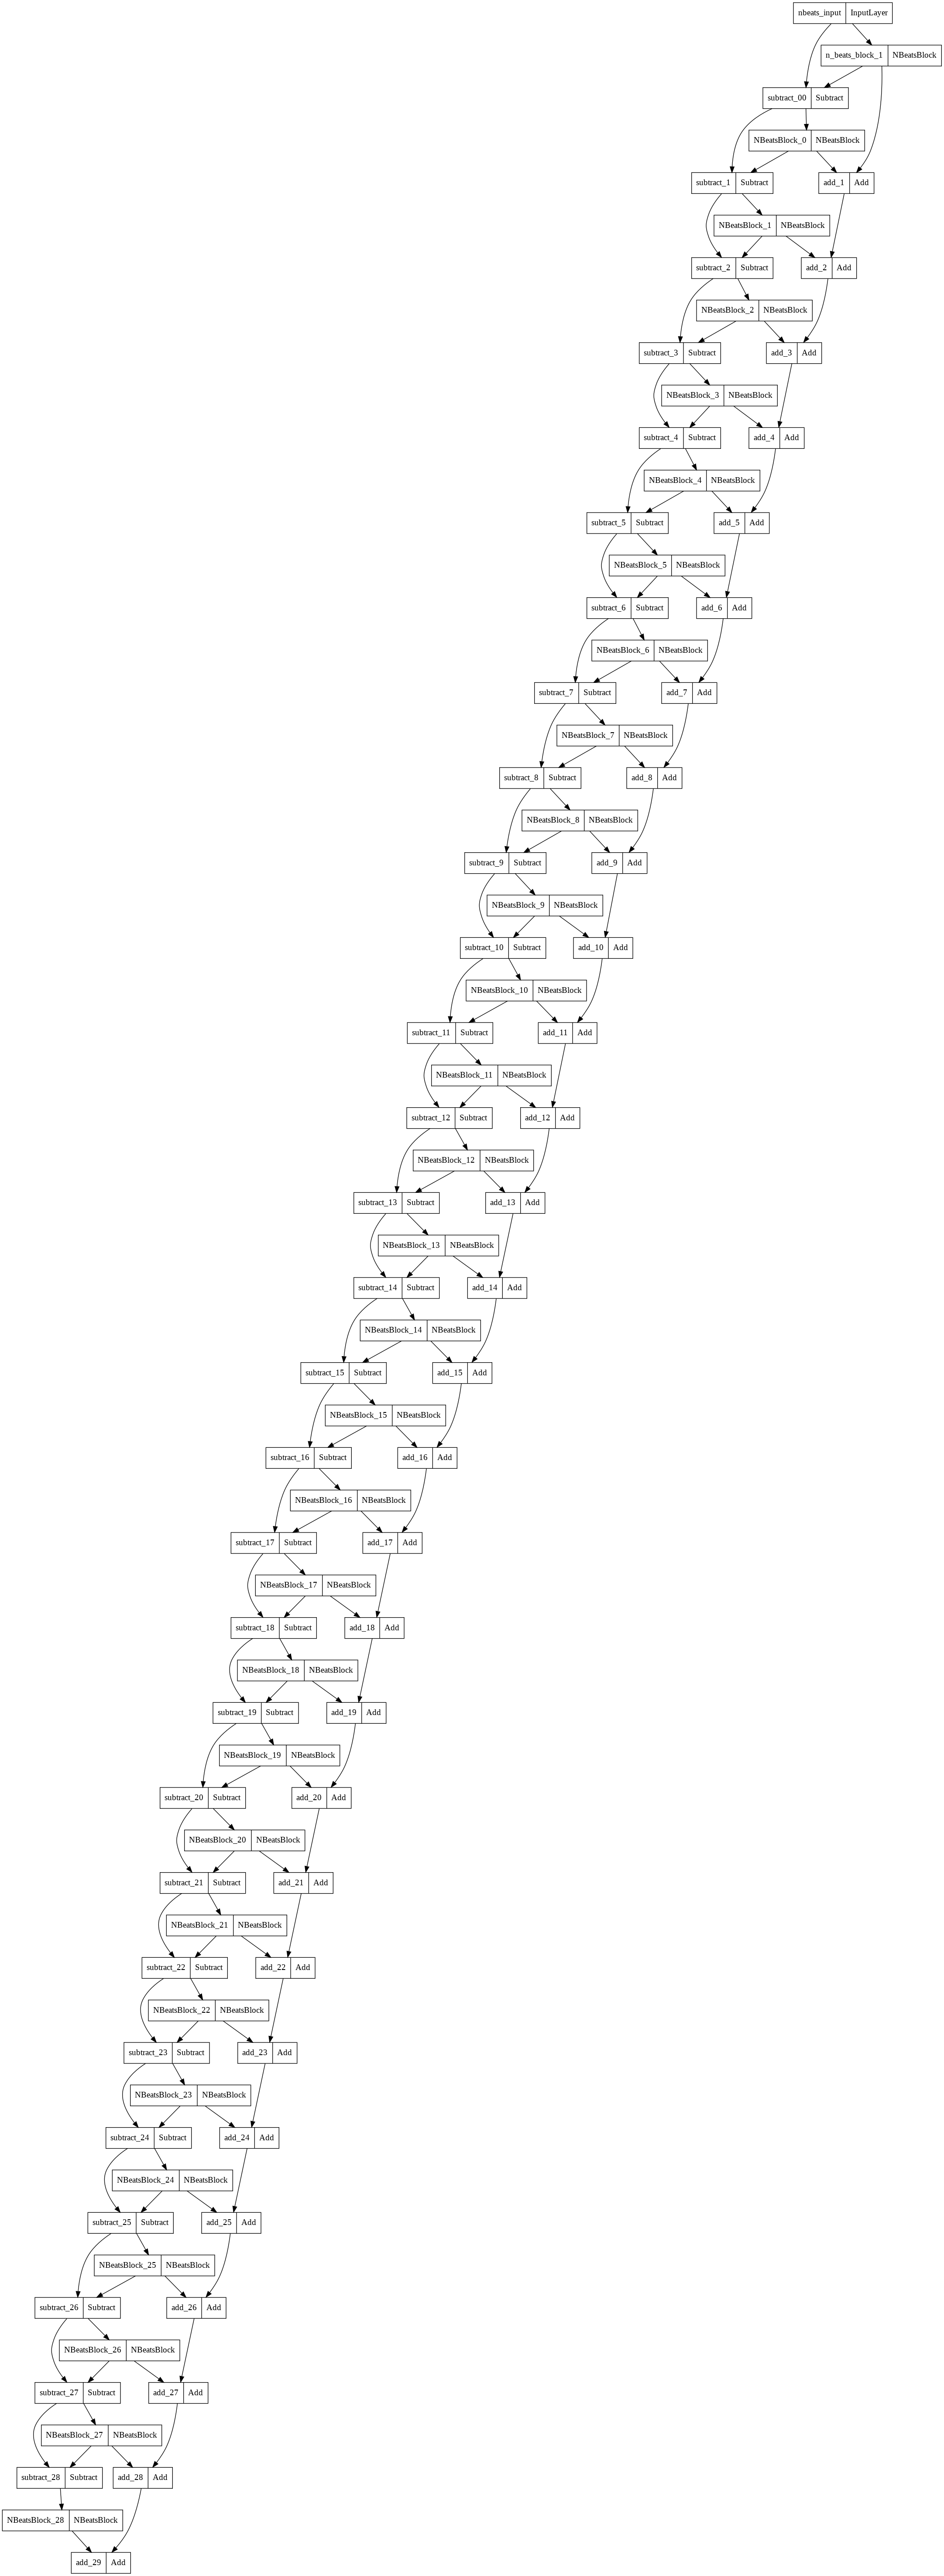

In [96]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [97]:
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_N-BEATS/assets


INFO:tensorflow:Assets written to: model_7_N-BEATS/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


##Model 8: Creating an ensemble (stacking different models together)

In [99]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_data,
                        test_data=test_data,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [100]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00246: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00346: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00114: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00161: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00300: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00400: ReduceLROnPlateau reducing learning rate to 1.000000047497451

In [101]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [102]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_data)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8806.48  ,  8780.449 ,  9016.457 , ..., 49657.25  , 48775.496 ,
        46776.055 ],
       [ 8723.897 ,  8727.639 ,  9080.058 , ..., 50434.84  , 48505.383 ,
        46661.01  ],
       [ 8790.645 ,  8801.172 ,  9088.752 , ..., 49775.566 , 48244.71  ,
        46123.88  ],
       ...,
       [ 8800.185 ,  8778.529 ,  9107.76  , ..., 49634.566 , 48783.098 ,
        46198.688 ],
       [ 8697.487 ,  8725.1875,  9039.816 , ..., 49587.137 , 48190.32  ,
        46020.188 ],
       [ 8842.634 ,  8812.006 ,  9067.661 , ..., 49909.934 , 48006.273 ,
        45911.316 ]], dtype=float32)>

In [103]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 565.3531,
 'mape': 2.553093,
 'mase': 0.9931688,
 'mse': 1148483.6,
 'rmse': 1071.6733}

In [104]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

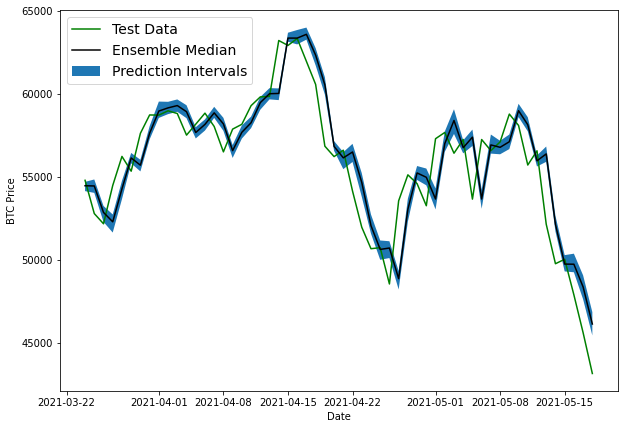

In [105]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);